## Entrenamiento de modelos ML para detección de accesos atípicos (IAM)

En este notebook se van a entrenar y evaluar diferentes modelos de detección de anomalías sobre el dataset generado en la fase de preparación. Dado que no existen etiquetas explícitas de anomalía en el dataset LANL, se van a aplicar técnicas no supervisadas / semi-supervisadas para identificar desviaciones respecto al comportamiento habitual.

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = "lanl_db_feature.csv"  # ajusta si tu fichero se llama distinto
df = pd.read_csv(DATA_PATH)

df.head()

,dt,src_user,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio
0,1970-01-01 00:00:00,ANONYMOUS LOGON@C1065,434,0,0.0,1,82,434,1.0
1,1970-01-01 00:00:00,U561@DOM1,17,0,0.0,3,4,17,1.0
2,1970-01-01 00:00:00,U556@DOM1,20,0,0.0,5,4,20,1.0
3,1970-01-01 00:00:00,U555@DOM1,49,0,0.0,9,10,49,1.0
4,1970-01-01 00:00:00,U553@DOM1,30,0,0.0,6,7,30,1.0


In [2]:
#ocupación en memoria del csv en MB
df.memory_usage(deep=True).sum() / (1024**2) 

np.float64(4195.788251876831)

In [3]:
#Nos indica cuantos perfiles de comportamiento hay
print("Shape:", df.shape)

Shape: (42866142, 9)


In [4]:
#Se comprueban valores nulos y se ordenan las columnas que muestran las diez peores ventanas de comportamiento.
print(df.isna().mean().sort_values(ascending=False).head(10))

dt                0.0
src_user          0.0
total_events      0.0
failed_events     0.0
fail_ratio        0.0
dst_hosts         0.0
src_hosts         0.0
nbhours_events    0.0
nbhours_ratio     0.0
dtype: float64


In [5]:
#Se generan estadisticas más descriptivas para comprobar el estado del dataset
df.describe()

,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio
count,4.286614e+07,4.286614e+07,4.286614e+07,4.286614e+07,4.286614e+07,4.286614e+07,4.286614e+07
mean,2.444509e+01,2.980180e-01,1.314286e-02,2.900863e+00,3.393979e+00,6.157894e+00,2.396926e-01
std,1.179786e+02,1.218741e+01,1.108429e-01,2.717707e+00,1.266600e+01,6.128290e+01,4.268958e-01
min,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,1.100000e+01,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
75%,2.500000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
max,1.807300e+04,4.608000e+03,1.000000e+00,2.751000e+03,2.026000e+03,1.371200e+04,1.000000e+00


## Fase 1: Selección de variables

Se van a seleccionar características numéricas que más representan el comportamiento IAM:
volumen de actividad, fallos, diversidad de hosts y actividad fuera de horario.


In [6]:
#Seleccionamos las columnas con las que vamos a trabajar en el dataset, en este caso, hay columnas que no son necesarias para entrenar a nuestras IAs
DB_COLS = [
    "total_events",
    "failed_events",
    "fail_ratio",
    "dst_hosts",
    "src_hosts",
    "nbhours_events",
    "nbhours_ratio"
]

#Comprobamos que las columnas son las que se encuentran en el documento
miss = [c for c in DB_COLS if c not in df.columns]
miss

[]

In [7]:
#última limpieza del dataset antes de empezar el entrenamiento

# Se sustituyen valores infinitos por 0
db = df[DB_COLS].replace([np.inf, -np.inf], np.nan).fillna(0)

db.head()


,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio
0,434,0,0.0,1,82,434,1.0
1,17,0,0.0,3,4,17,1.0
2,20,0,0.0,5,4,20,1.0
3,49,0,0.0,9,10,49,1.0
4,30,0,0.0,6,7,30,1.0


Dado que las variables presentan escalas y magnitudes muy diferentes, se va a aplicar una normalización previa al entrenamiento de los modelos. Este proceso evita que las características de mayor rango dominen el aprendizaje y permite que todas las variables contribuyan de forma equilibrada a la detección de accesos atípicos.

In [8]:
#Normalización del dataset para empezar a entrenar a los modelos de aprendizaje automático
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
db_scaled = scaler.fit_transform(db)
db_scaled.shape

(42866142, 7)

## Isolation Forest

Modelo no supervisado que aísla observaciones raras mediante particiones aleatorias.
Es adecuado para detección de outliers en grandes volúmenes y se utiliza cuando no existen etiquetas.
está inspirado en el algoritmo de clasificación y regresión Random Forest.
El modelo Isolation Forest está formado por la combinación de múltiples árboles llamados isolation trees. Estos árboles se crean de forma similar a los de clasificación-regresión: las observaciones de entrenamiento se van separando de forma recursiva creando las ramas del árbol hasta que cada observación queda aislada en un nodo terminal. Sin embargo, en los isolation tree, la selección de los puntos de división se hace de forma aleatoria. Aquellas observaciones con características distintas al resto, quedarán aisladas a las pocas divisiones, por lo que el número de nodos necesarios para llegar a esta observación desde el inicio del árbol (profundidad) es menor que para el resto.

El modelo Isolation Forest se obtiene al combinar múltiples isolation tree, cada uno entrenado con una muestra distinta generada por bootstrapping a partir de los datos de originales. El valor predicho para cada observacion es el número de divisiones promedio que se han necesitado para aislar dicha observacion en el conjunto de árboles. Cuanto menor es este valor, mayor es la probabilidad de que se trate de una anomalía.


In [ ]:
from sklearn.ensemble import IsolationForest

# contamination = proporción esperada de anomalías (hiperparámetro)
# Se va a empezar entre el rango de 0.01–0.05
iso = IsolationForest(
    n_estimators=200, #Número de árboles en el bosque
    contamination=0.05, #Proporción esperada de anomalías 
    random_state=42, #Reproducibilidad
    n_jobs=-1 #se usan todos los núcleos de CPu disponibles
)

iso.fit(db_scaled)


,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",200
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.05
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [ ]:
# decision_function: mayor => más normal. Menor => más anómalo
df["iso_score"] = iso.decision_function(db_scaled)

# predict: 1 normal, -1 anómalo
df["iso_label"] = iso.predict(db_scaled)

df[["iso_score", "iso_label"]].describe()
df["iso_label"].value_counts()

iso_label
 1    40722903
-1     2143239
Name: count, dtype: int64

In [ ]:
#Se van a guardar los resultados del entrenamiento para poder evaluarlos posteriormente 
out_if = pd.DataFrame({
    "iso_score": df["iso_score"].values,
    "iso_label": df["iso_label"].values
})

# Se añade trazabilidad si existe (Quién y cuando)
if "dt" in df.columns:
    out_if["dt"] = df["dt"].values
if "src_user" in df.columns:
    out_if["src_user"] = df["src_user"].values

out_if.to_parquet("isolation_forest.parquet", index=False)
print("Isolation Forest guardado:", out_if.shape)

Isolation Forest guardado: (42866142, 4)


In [ ]:
import json

run_if_info = {
    "model": "IsolationForest",
    "features": DB_COLS,
    "scaler": "StandardScaler",
    "params": {
        "n_estimators": 200,
        "contamination": 0.05,
        "random_state": 42
    }
}

with open("run_if_info.json", "w") as f:
    json.dump(run_if_info, f, indent=2)

print("Metadatos de IF guardados")

Metadatos de IF guardados


### Hipótesis — Isolation Forest

Se ha entrenado Isolation Forest sobre perfiles horarios y se ha obtenido un score continuo de anomalía, permitiendo generar un ranking Top-K de accesos potencialmente atípicos para revisión.
La distribución del score permite evaluar la presencia de una cola de anomalías, y el Top-K facilita el análisis cualitativo y la estimación de métricas operativas como Precision@K y tasa de falsos positivos mediante revisión manual.

## Autoencoders
Autoencoders es un tipo de red neuronal que se utiliza para el aprendizaje no supervisado. Su función principal es aprender una representación comprimida de los datos de entrada. Consta de dos partes principales: el codificador y el decodificador.

Codificador: Esta parte de la red comprime la entrada en una representación en espacio latente. Codifica los datos de entrada como una representación codificada (comprimida) en una dimensión reducida.
Decodificador: El decodificador tiene como objetivo reconstruir los datos de entrada a partir de la representación codificada. Intenta generar una salida lo más cercana posible a la entrada original.

La idea clave es que autoencoders se entrena para minimizar los errores de reconstrucción, lo que los hace eficientes en el aprendizaje de la distribución de los datos de entrada.

In [9]:
#Preparación de los datos normalizados. Se usa float32 y mini-batches para evitar usar una memoria elevada.
db_ae = db_scaled.astype(np.float32)
db_ae.shape, db_ae.dtype

((42866142, 7), dtype('float32'))

In [10]:
#se importan librerías y se indica donde entrenar el modelo
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
print("Filas:", db_scaled.shape[0])
print("Features:", db_scaled.shape[1])

# tamaño aproximado de X_ae en RAM si es float32
approx_gb = db_scaled.shape[0] * db_scaled.shape[1] * 4 / (1024**3)
print(f"Tamaño aprox float32: {approx_gb:.2f} GB")


Filas: 42866142
Features: 7
Tamaño aprox float32: 1.12 GB


In [12]:
# Se crea el dataLoader para entregar los datos en lotes (batches)
#Se usa Pytorch para crear este dataset para el modelo
BATCH_SIZE = 4096

dataset = TensorDataset(torch.from_numpy(db_ae))
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, #se mezclan filas para que el modelo no vea patrones por orden temporal
    drop_last=False #para no perder filas
)

Define un autoencoder:

Encoder: comprime el vector de features.
Decoder: intenta reconstruir el vector original.

In [13]:
#Se define el modelo
input_dim = db_ae.shape[1]
latent_dim = max(2, input_dim // 2)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

ae = AutoEncoder(input_dim, latent_dim).to(device)
ae

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=7, bias=True)
  )
)

In [14]:
#Entrenamiento del modelos para minimizar el error de reconstrucción
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

EPOCHS = 5

ae.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    n = 0

    for (batch,) in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = ae(batch)
        loss = loss_fn(recon, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.size(0)
        n += batch.size(0)

    print(f"Epoch {epoch}/{EPOCHS} - MSE: {total_loss/n:.6f}")

Epoch 1/5 - MSE: 0.060197
Epoch 2/5 - MSE: 0.010502
Epoch 3/5 - MSE: 0.009368
Epoch 4/5 - MSE: 0.008653
Epoch 5/5 - MSE: 0.008531


In [15]:
#Proceso de scoring
ae.eval()
scores = np.empty(len(db_ae), dtype=np.float32)

with torch.no_grad():
    start = 0
    eval_loader = DataLoader(
        TensorDataset(torch.from_numpy(db_ae)),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    for (batch,) in eval_loader:
        batch = batch.to(device)
        recon = ae(batch)
        mse = ((recon - batch) ** 2).mean(dim=1).cpu().numpy()

        end = start + len(mse)
        scores[start:end] = mse
        start = end

df["ae_score"] = scores
df["ae_score"].describe()

count    4.286614e+07
mean     7.625117e-03
std      1.785400e+00
min      5.507736e-05
25%      1.082168e-04
50%      1.560334e-04
75%      2.956481e-04
max      6.295241e+03
Name: ae_score, dtype: float64

In [20]:
#Guardar resultado 

out_ae = pd.DataFrame({
    "ae_score": df["ae_score"].values
})

if "dt" in df.columns:
    out_ae["dt"] = df["dt"].values
if "src_user" in df.columns:
    out_ae["src_user"] = df["src_user"].values

out_ae.to_parquet("autoencoders.parquet", index=False)
print("Autoencoder guardado:", out_ae.shape)

Autoencoder guardado: (42866142, 3)


In [19]:
#Guardar metadatos del experimento
import json

run_ae_info = {
    "model": "Autoencoder",
    "features": DB_COLS,
    "scaler": "StandardScaler",
    "params": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "latent_dim": latent_dim,
        "optimizer": "Adam",
        "loss": "MSE"
    }
}

with open("run_ae_info.json", "w") as f:
    json.dump(run_ae_info, f, indent=2)

print("Metadatos del Autoencoder guardados")


Metadatos del Autoencoder guardados


## EVALUACIÓN DE RESULTADOS QUE MOVERÉ A UN CUARTO NOTEBOOK

In [17]:
# Top anomalías (scores más bajos)
top_k = 20
top_anom = df.nsmallest(top_k, "iso_score")

cols_to_show = ["dt", "src_user"] if "dt" in df.columns and "src_user" in df.columns else []
cols_to_show += DB_COLS + ["iso_score", "iso_label"]

top_anom[cols_to_show].head(top_k)

,dt,src_user,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio,iso_score,iso_label
19909164,1970-01-31 00:00:00,U78@?,749,749,1.000000,26,26,749,1.0,-0.207086,-1
19955107,1970-01-31 01:00:00,U78@?,728,728,1.000000,26,26,728,1.0,-0.207086,-1
20004432,1970-01-31 04:00:00,U78@?,758,758,1.000000,26,26,758,1.0,-0.207086,-1
20049426,1970-01-31 05:00:00,U78@?,729,729,1.000000,26,26,729,1.0,-0.207086,-1
19981206,1970-01-31 03:00:00,U78@?,569,569,1.000000,26,26,569,1.0,-0.201606,-1
20064610,1970-01-31 06:00:00,U78@?,581,581,1.000000,28,28,581,1.0,-0.201606,-1
19968992,1970-01-31 02:00:00,U78@?,553,553,1.000000,26,26,553,1.0,-0.201031,-1
19965294,1970-01-31 02:00:00,U78@?,405,405,1.000000,26,26,405,1.0,-0.200169,-1
20060604,1970-01-31 06:00:00,U78@?,424,424,1.000000,22,22,424,1.0,-0.199596,-1
38430954,1970-02-23 03:00:00,U22@DOM1,5175,465,0.089855,20,16,5175,1.0,-0.199309,-1


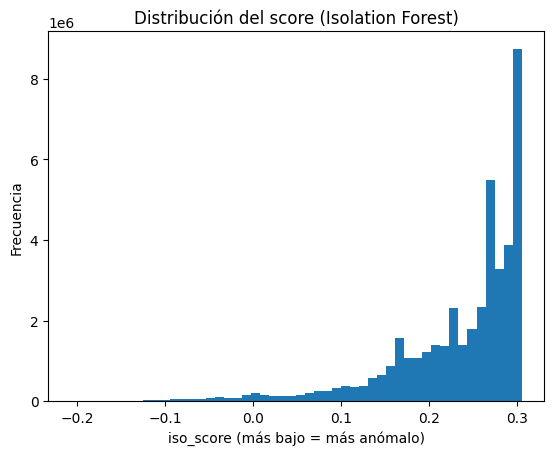

In [ ]:
#Distribución de scores (histograma)
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["iso_score"], bins=50)
plt.title("Distribución del score (Isolation Forest)")
plt.xlabel("iso_score (más bajo = más anómalo)")
plt.ylabel("Frecuencia")
plt.show()

In [19]:
normal_mean = df[df["iso_label"] == 1][DB_COLS].mean()
anom_mean = df[df["iso_label"] == -1][DB_COLS].mean()

summary = pd.DataFrame({"normal_mean": normal_mean, "anom_mean": anom_mean})
summary["ratio_anom_vs_normal"] = summary["anom_mean"] / (summary["normal_mean"] + 1e-9)
summary.sort_values("ratio_anom_vs_normal", ascending=False)


,normal_mean,anom_mean,ratio_anom_vs_normal
failed_events,0.022212,13.813992,621.925631
fail_ratio,0.005675,0.379083,66.793007
nbhours_events,3.835228,119.980832,31.283886
total_events,19.162046,283.342239,14.786638
src_hosts,3.158245,14.946201,4.732439
dst_hosts,2.821705,6.780042,2.402817
nbhours_ratio,0.234298,0.504034,2.151247


In [20]:
#muestra aleatoria de top anomalías
top_anom.sample(5, random_state=42)[["dt","src_user"] + DB_COLS + ["iso_score"]]

,dt,src_user,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio,iso_score
19909164,1970-01-31 00:00:00,U78@?,749,749,1.000000,26,26,749,1.0,-0.207086
2278527,1970-01-05 02:00:00,U22@DOM1,7595,536,0.070573,19,16,7595,1.0,-0.198449
7167803,1970-01-12 02:00:00,U22@DOM1,7221,586,0.081152,18,16,7221,1.0,-0.198736
19955107,1970-01-31 01:00:00,U78@?,728,728,1.000000,26,26,728,1.0,-0.207086
20060604,1970-01-31 06:00:00,U78@?,424,424,1.000000,22,22,424,1.0,-0.199596


In [ ]:
# % anomalías detectadas - Resumen cuantitativo del modelo
counts = df["iso_label"].value_counts()
total = len(df)
n_anom = int(counts.get(-1, 0))
print("Total perfiles:", total)
print("Anomalías (label=-1):", n_anom, f"({n_anom/total:.2%})")
print("Normales (label=1):", int(counts.get(1, 0)), f"({counts.get(1,0)/total:.2%})")

Total perfiles: 42866142
Anomalías (label=-1): 857232 (2.00%)
Normales (label=1): 42008910 (98.00%)


In [22]:
#Top 50 anomalías tabla por revisión
TOP_K = 50

show_cols = []
for c in ["dt", "src_user"]:
    if c in df.columns:
        show_cols.append(c)

show_cols += DB_COLS + ["iso_score", "iso_label"]

top_if = df.nsmallest(TOP_K, "iso_score")[show_cols]
top_if.head(20)


,dt,src_user,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio,iso_score,iso_label
19909164,1970-01-31 00:00:00,U78@?,749,749,1.000000,26,26,749,1.0,-0.207086,-1
19955107,1970-01-31 01:00:00,U78@?,728,728,1.000000,26,26,728,1.0,-0.207086,-1
20004432,1970-01-31 04:00:00,U78@?,758,758,1.000000,26,26,758,1.0,-0.207086,-1
20049426,1970-01-31 05:00:00,U78@?,729,729,1.000000,26,26,729,1.0,-0.207086,-1
19981206,1970-01-31 03:00:00,U78@?,569,569,1.000000,26,26,569,1.0,-0.201606,-1
20064610,1970-01-31 06:00:00,U78@?,581,581,1.000000,28,28,581,1.0,-0.201606,-1
19968992,1970-01-31 02:00:00,U78@?,553,553,1.000000,26,26,553,1.0,-0.201031,-1
19965294,1970-01-31 02:00:00,U78@?,405,405,1.000000,26,26,405,1.0,-0.200169,-1
20060604,1970-01-31 06:00:00,U78@?,424,424,1.000000,22,22,424,1.0,-0.199596,-1
38430954,1970-02-23 03:00:00,U22@DOM1,5175,465,0.089855,20,16,5175,1.0,-0.199309,-1
